<a href="https://colab.research.google.com/github/h30e07/E4sosei/blob/main/2nen3nen_class_var.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# similarityの算出方法

$$
similarity = \dfrac{1}{|A-A\cap{B}||B-A\cap{B}|}{\sum_{w_a\in{(A-A\cap{B})}}}\;{\sum_{w_b\in{(B-A\cap{B})}}}f(w_a, w_b)
\\A:シラバスAに現れる全単語の集合,
\\B:シラバスBに現れる全単語の集合,
\\f(w_a, w_b):単語w_aと単語w_bの関連度合いを-1～1の値で返す関数,
$$


# Google Drive マウント
（一番最初にこれを実行してください）

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# シラバスクラス

In [ ]:
import re
class Syllabus:
    def __init__(self, path):
        self.path = path
        self.subject_name = re.sub('([0-9]+)', '', path.replace('/content/drive/MyDrive/sosei/meishi/meishi_', '').replace('.txt', '')).replace('()', '').replace('（）', '')
        self.subject_code = re.search('[0-9]{4}', path).group()
        self.grade = re.findall('_([0-9]{1})', path)[0]
        self.words = ""
        self.words_set = {}
        self.remained_set = {}

    def set_words_set(self):
        with open(self.path) as s:
            self.words = s.read()
        self.words_set = set(self.words.split())
        return self.words_set
    
    def calc_remained_set(self, another_s_words_set):
        self.remained_set = self.words_set - (self.words_set & another_s_words_set)
        return self.remained_set

    def get_dict():
        output = {
            'path': self.path,
            'words': self.words,
            'words_set': self.words_set,
            'remained_set': self.remained_set
        }
        return output

# get_all_combinations関数

In [ ]:
def get_all_combinations(sa_words, sb_words):
    all_combinations = []
    for sa_word in sa_words:
        for sb_word in sb_words:
            try:
                all_combinations.append(
                    {
                        'word1': sa_word,
                        'word2': sb_word,
                        'similarity': float(w2v_model.similarity(sa_word, sb_word))
                    }
                )
            except KeyError:
                pass
    sorted_all_combinations = sorted(all_combinations, key=lambda x: x['similarity'], reverse=True)
    return sorted_all_combinations

# 関連性クラス

In [ ]:
class Similarity:
    def __init__(self, words_combinations):
        self.words_combinations = words_combinations
        self.similarity = 0
        self.key_data = {}
        self.distribution = []

    def calc_similarity(self, sa_words_count, sb_words_count):
        for  word_combination in self.words_combinations:
            self.similarity += word_combination['similarity']
        self.similarity /= (sa_words_count * sb_words_count)
        return self.similarity
    
    def set_key_data(self, sa_subject_name, sb_subject_name):
        self.key_data = {
            'word_combination_sum': len(self.words_combinations),
            'min_similarity_value': self.words_combinations[-1]['similarity'],
            'max_similarity_value': self.words_combinations[0]['similarity'],
            'distribution': self.show_distribution(sa_subject_name, sb_subject_name)
        }
        return self.key_data


    def show_distribution(self, sa_subject_name, sb_subject_name):
        import numpy as np
        import pandas as pd
        import matplotlib.pyplot as plt
        fig = plt.figure()
        similarity_list = [d.get('similarity') for d in self.words_combinations]
        bins = np.arange(-1, 1, 0.1) # 等差数列
        sr = pd.Series(similarity_list)
        sr1 = pd.cut(sr, bins=bins)
        vc = sr1.value_counts(sort=False)
        y, ind, pacthes = plt.hist(sr,bins = bins.size-2, range =(-1,1))
        print('y', y)
        print('ind', ind)
        plt.xlabel("similarity")
        plt.ylabel("number of combinations")
        # plt.title(f"{sa_path.replace('/content/drive/MyDrive/sosei/meishi/meishi_', '')}, {sb_path.replace('/content/drive/MyDrive/sosei/meishi/meishi_', '')}", fontname="MS Gothic")
        plt.show()
        fig.savefig(f"/content/drive/MyDrive/imgs/{sa_subject_name}_{sb_subject_name}.png")
        return self.distribution
    
    def get_dict(self):
        output = {
            'similarity': self.similarity,
            'key_data': self.key_data,
            'words_combinations': self.words_combinations,
        }
        return output

# シラバスの全組み合わせを返す関数

In [ ]:
def get_all_syllabus_combination():
    import glob
    import itertools
    output = []
    files = glob.glob(f"/content/drive/MyDrive/sosei/meishi/*")
    print(len(files))
    output = list(itertools.combinations(files, 2))
    return output

In [ ]:
def syllabus_similarity(sa_path, sb_path):
    """
    メイン関数。
    入力の2つのファイルから求められたあらゆるデータは変数outputに格納される。

    Parameters
    ----------
    sa_path : string
        シラバスaの形態素解析済みのファイルのパス
    sb_path : string
        シラバスbの形態素解析済みのファイルのパス
    """
    
    sa = Syllabus(sa_path)
    sb = Syllabus(sb_path)
    sa.set_words_set()
    sb.set_words_set()
    sa.calc_remained_set(sb.words_set)
    sb.calc_remained_set(sa.words_set)

    # 本処理    
    similarity = Similarity(get_all_combinations(sa.remained_set, sb.remained_set))
    if len(sa.remained_set) != 0  and len(sb.remained_set) != 0:   # 2つが部分集合出ないとき
        similarity.calc_similarity(len(sa.remained_set), len(sb.remained_set))
        similarity.set_key_data(sa.subject_name, sb.subject_name)
    else:
        similarity.similarity = 1
    
    output = {
        'subject_combination': [sa.path, sb.path],
        'data': similarity.get_dict()
    }
    print('output', output)
    return output

# メインプログラム　AかつBの単語を取り除く(0かける)
（準備ができたらこれを実行してください）


45
suject_number 0078
grade 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  # Remove the CWD from sys.path while we load stuff.


y [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.800e+01 2.980e+02
 1.229e+03 2.401e+03 2.652e+03 2.073e+03 1.085e+03 5.040e+02 2.200e+02
 6.700e+01 1.700e+01 1.500e+01 1.000e+00]
ind [-1.         -0.88888889 -0.77777778 -0.66666667 -0.55555556 -0.44444444
 -0.33333333 -0.22222222 -0.11111111  0.          0.11111111  0.22222222
  0.33333333  0.44444444  0.55555556  0.66666667  0.77777778  0.88888889
  1.        ]


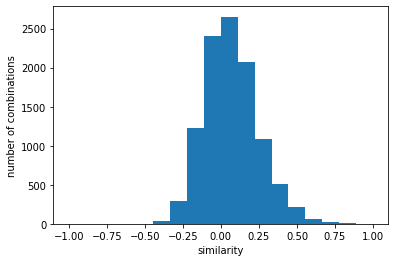

output {'subject_combination': ['/content/drive/MyDrive/sosei/meishi/meishi_1基礎数学E(0078).txt', '/content/drive/MyDrive/sosei/meishi/meishi_1ものづくり基礎(0907).txt'], 'data': {'similarity': 0.06560730489143762, 'key_data': {'word_combination_sum': 10600, 'min_similarity_value': -0.4208455979824066, 'max_similarity_value': 0.8986603021621704, 'distribution': []}, 'words_combinations': [{'word1': '和田', 'word2': '戸田', 'similarity': 0.8986603021621704}, {'word1': '60', 'word2': '36', 'similarity': 0.8791563510894775}, {'word1': '和田', 'word2': '新井', 'similarity': 0.8777042627334595}, {'word1': '佐々木', 'word2': '新井', 'similarity': 0.8694973587989807}, {'word1': '吉田', 'word2': '戸田', 'similarity': 0.8662998676300049}, {'word1': '70', 'word2': '36', 'similarity': 0.8584537506103516}, {'word1': '吉田', 'word2': '新井', 'similarity': 0.8558469414710999}, {'word1': '30', 'word2': '36', 'similarity': 0.8311585187911987}, {'word1': '裕', 'word2': '新井', 'similarity': 0.8271984457969666}, {'word1': '博子', 'word2'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  # Remove the CWD from sys.path while we load stuff.


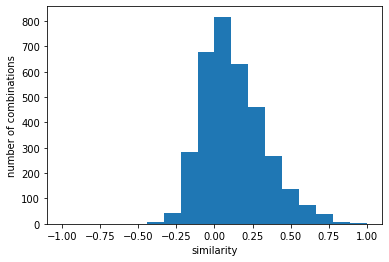

output {'subject_combination': ['/content/drive/MyDrive/sosei/meishi/meishi_1基礎数学E(0078).txt', '/content/drive/MyDrive/sosei/meishi/meishi_1基礎数学B(0075).txt'], 'data': {'similarity': 0.11663431894650814, 'key_data': {'word_combination_sum': 3445, 'min_similarity_value': -0.4064226746559143, 'max_similarity_value': 0.9487748146057129, 'distribution': []}, 'words_combinations': [{'word1': '09', 'word2': '06', 'similarity': 0.9487748146057129}, {'word1': '後期', 'word2': '前期', 'similarity': 0.8971942663192749}, {'word1': '論理', 'word2': '解法', 'similarity': 0.8510696887969971}, {'word1': '命題', 'word2': '解法', 'similarity': 0.827930212020874}, {'word1': '法則', 'word2': '解法', 'similarity': 0.8274044990539551}, {'word1': '論理', 'word2': '関数', 'similarity': 0.7983258962631226}, {'word1': '命題', 'word2': '関数', 'similarity': 0.7914007902145386}, {'word1': '採点', 'word2': '出題', 'similarity': 0.7826205492019653}, {'word1': '論理', 'word2': '導出', 'similarity': 0.7635409832000732}, {'word1': '帰納', 'word2': '解法

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  # Remove the CWD from sys.path while we load stuff.


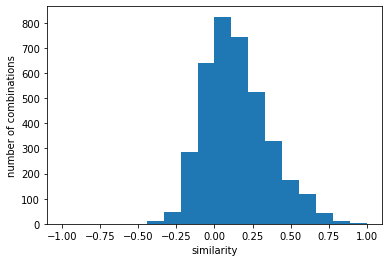

output {'subject_combination': ['/content/drive/MyDrive/sosei/meishi/meishi_1基礎数学E(0078).txt', '/content/drive/MyDrive/sosei/meishi/meishi_1基礎数学C(0076).txt'], 'data': {'similarity': 0.12616345685825986, 'key_data': {'word_combination_sum': 3752, 'min_similarity_value': -0.4459872245788574, 'max_similarity_value': 0.9490115642547607, 'distribution': []}, 'words_combinations': [{'word1': '09', 'word2': '07', 'similarity': 0.9490115642547607}, {'word1': '後期', 'word2': '前期', 'similarity': 0.8971942663192749}, {'word1': 'F', 'word2': 'D', 'similarity': 0.8947606086730957}, {'word1': 'A', 'word2': 'C', 'similarity': 0.8918637633323669}, {'word1': '法則', 'word2': '定理', 'similarity': 0.8660014867782593}, {'word1': '命題', 'word2': '定理', 'similarity': 0.8626354932785034}, {'word1': '論理', 'word2': '定理', 'similarity': 0.8565655946731567}, {'word1': '論理', 'word2': '解法', 'similarity': 0.8510696887969971}, {'word1': 'F', 'word2': 'C', 'similarity': 0.838302731513977}, {'word1': 'A', 'word2': 'D', 'simi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  # Remove the CWD from sys.path while we load stuff.


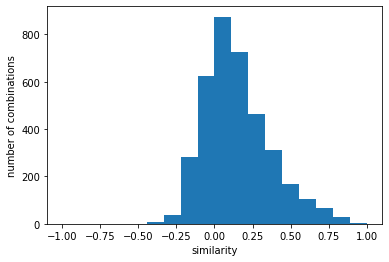

output {'subject_combination': ['/content/drive/MyDrive/sosei/meishi/meishi_1基礎数学E(0078).txt', '/content/drive/MyDrive/sosei/meishi/meishi_1基礎数学A(0074).txt'], 'data': {'similarity': 0.13126834274280785, 'key_data': {'word_combination_sum': 3696, 'min_similarity_value': -0.4308125972747803, 'max_similarity_value': 0.9219720959663391, 'distribution': []}, 'words_combinations': [{'word1': '09', 'word2': '05', 'similarity': 0.9219720959663391}, {'word1': '等式', 'word2': '乗法', 'similarity': 0.9199072122573853}, {'word1': 'すべて', 'word2': '全て', 'similarity': 0.9077157974243164}, {'word1': '後期', 'word2': '前期', 'similarity': 0.8971942663192749}, {'word1': '等式', 'word2': '次数', 'similarity': 0.8833973407745361}, {'word1': '等式', 'word2': '加法', 'similarity': 0.8743259906768799}, {'word1': '等式', 'word2': '複素', 'similarity': 0.8655736446380615}, {'word1': '等式', 'word2': '実数', 'similarity': 0.8649446964263916}, {'word1': '等式', 'word2': '除法', 'similarity': 0.8563663363456726}, {'word1': '10', 'word2': '

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  # Remove the CWD from sys.path while we load stuff.


KeyboardInterrupt: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
from gensim.models.word2vec import Word2Vec
from google.colab import files
import csv
import json

def test():
    syllabus_path = [
        '/content/drive/MyDrive/sosei/meishi/meishi_3電気回路ⅠA(2078).txt',
        '/content/drive/MyDrive/sosei/meishi/meishi_3電気回路ⅠB(2079).txt',
        '/content/drive/MyDrive/sosei/meishi/meishi_2微分積分学ⅠA(0018).txt'
    ]
    
    output.append(syllabus_similarity(syllabus_path[0], syllabus_path[0]))
    output.append(syllabus_similarity(syllabus_path[0], syllabus_path[1]))
    output.append(syllabus_similarity(syllabus_path[0], syllabus_path[2]))  
  
if __name__ == '__main__':
    output = []
    W2V_MODEL_PATH = '/content/drive/MyDrive/sosei/Pre-Trained Word2Vec Models/latest-ja-word2vec-gensim-model/word2vec.gensim.model'
    w2v_model = Word2Vec.load(W2V_MODEL_PATH)
    for combination in get_all_syllabus_combination():
      output.append(syllabus_similarity(combination[0], combination[1]))
    ### このプログラムを実行して得られた全てのデータをファイル出力 ###
    with open(f"/content/drive/MyDrive/v2.json", 'w') as f:
        json.dump(output, f, indent=2, ensure_ascii=False)